# Exploratory data analysis for $\tau\to \mathrm{track} + X$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize

from pdflib import normal, double_normal, exp_gauss_exp, exp_double_gauss_exp
from llhlib import loglh_maker, normalize
from plotlib import poisson_hist, fit_plot, plot_scatter
import glob
matplotlib.rcParams['font.size'] = 16

In [2]:
files = sorted(glob.glob('./csv/*.csv'))
print('\n'.join(files))

./csv/taumuthr.csv
./csv/tup.csv
./csv/tupd0gamgam.csv
./csv/tupdbltau.csv
./csv/tupdpkpipi.csv
./csv/tupfulldkpidgg.csv


In [3]:
df = pd.read_csv(files[0])
df.shape

(127671, 15)

In [4]:
df.columns

Index(['Unnamed: 0', 'evtn', 'tau_pi_p', 'tau_pi_pt', 'tau_pi_costh',
       'tau_pi_dedx', 'tau_pi_pidkpi', 'tau_pi_pidkp', 'tau_pi_pidmupi',
       'tau_pi_pide', 'tau_pi_charge', 'tau_pi_px_mc', 'tau_pi_py_mc',
       'tau_pi_pz_mc', 'tau_pi_pdgid_mc'],
      dtype='object')

In [5]:
df.head()

,Unnamed: 0,evtn,tau_pi_p,tau_pi_pt,tau_pi_costh,tau_pi_dedx,tau_pi_pidkpi,tau_pi_pidkp,tau_pi_pidmupi,tau_pi_pide,tau_pi_charge,tau_pi_px_mc,tau_pi_py_mc,tau_pi_pz_mc,tau_pi_pdgid_mc
0,0,0,0.711757,0.704027,-0.146983,500.502747,0.982071,14.0,17.774511,0.0,1.0,-0.161599,0.685592,-0.106126,211.0
1,1,0,0.000000,0.000000,NaN,0.000000,0.960897,4.0,10.285098,0.0,-1.0,-0.305835,0.093459,0.170047,13.0
2,2,1,0.381669,0.307896,-0.590949,428.694336,-1.000000,2.0,0.565743,0.0,1.0,0.258055,0.167764,-0.223539,211.0
3,3,1,0.340336,0.161308,0.880543,601.912415,0.000000,0.0,0.000000,0.0,-1.0,0.140516,-0.075606,0.295445,-211.0
4,4,2,0.000000,0.000000,NaN,0.000000,0.987016,25.0,25.175167,0.0,1.0,0.539237,0.434145,0.539095,211.0


In [6]:
df = df.dropna()
df['tau_pi_pidkpi'] = df['tau_pi_pidkpi'].apply(lambda x: 0. if x < 0 else x)
df['beta'] = df['tau_pi_pidkpi']
df['nphe'] = df['tau_pi_pidkp']
df['dedx'] = df['tau_pi_dedx']
df['p'] = df['tau_pi_p']
df['pt'] = df['tau_pi_pt']

In [7]:
df.head()

,Unnamed: 0,evtn,tau_pi_p,tau_pi_pt,tau_pi_costh,tau_pi_dedx,tau_pi_pidkpi,tau_pi_pidkp,tau_pi_pidmupi,tau_pi_pide,tau_pi_charge,tau_pi_px_mc,tau_pi_py_mc,tau_pi_pz_mc,tau_pi_pdgid_mc,beta,nphe,dedx,p,pt
0,0,0,0.711757,0.704027,-0.146983,500.502747,0.982071,14.0,17.774511,0.0,1.0,-0.161599,0.685592,-0.106126,211.0,0.982071,14.0,500.502747,0.711757,0.704027
2,2,1,0.381669,0.307896,-0.590949,428.694336,0.000000,2.0,0.565743,0.0,1.0,0.258055,0.167764,-0.223539,211.0,0.000000,2.0,428.694336,0.381669,0.307896
3,3,1,0.340336,0.161308,0.880543,601.912415,0.000000,0.0,0.000000,0.0,-1.0,0.140516,-0.075606,0.295445,-211.0,0.000000,0.0,601.912415,0.340336,0.161308
5,5,2,0.596903,0.511387,-0.515760,441.106018,0.984431,22.0,21.885609,0.0,-1.0,0.440044,0.257627,-0.308306,13.0,0.984431,22.0,441.106018,0.596903,0.511387
6,6,3,0.399839,0.366973,0.397036,460.289398,0.966666,14.0,13.293715,0.0,1.0,-0.364191,0.044590,0.161202,-13.0,0.966666,14.0,460.289398,0.399839,0.366973


In [8]:
df.shape

(108882, 20)

## PID MC Truth

In [9]:
etup = df[np.abs(df.tau_pi_pdgid_mc) == 11].copy()
etup.shape

(14514, 20)

In [10]:
mutup = df[np.abs(df.tau_pi_pdgid_mc) == 13].copy()
mutup.shape

(14355, 20)

In [11]:
pitup = df[np.abs(df.tau_pi_pdgid_mc) == 211].copy()
pitup.shape

(77175, 20)

In [12]:
ktup = df[np.abs(df.tau_pi_pdgid_mc) == 321].copy()
ktup.shape

(2838, 20)

## Pseudomass

In [13]:
def pseudomass(ph, mh, ebeam):
    eh = np.sqrt(mh**2 + ph**2)
    return np.sqrt(mh**2 + 2 * (ebeam - eh) * (eh - ph))

In [14]:
def pseudomissing_mass(ph, mh, ebeam):
    eh = np.sqrt(mh**2 + ph**2)
    return ebeam**2 + mh**2 - 2. * ebeam * eh

In [15]:
ebeam = 1.78
me = 0.000511
mmu = 0.105658
mpi = 0.139570
mk = .493677
mp = .93827231

In [16]:
etup['Mp'] = pseudomass(etup.tau_pi_p, me, ebeam)
etup['mmiss'] = pseudomissing_mass(etup.tau_pi_p, me, ebeam)

mutup['Mp'] = pseudomass(mutup.tau_pi_p, mmu, ebeam)
mutup['mmiss'] = pseudomissing_mass(mutup.tau_pi_p, mmu, ebeam)

pitup['Mp'] = pseudomass(pitup.tau_pi_p, mpi, ebeam)
pitup['mmiss'] = pseudomissing_mass(pitup.tau_pi_p, mpi, ebeam)

ktup['Mp'] = pseudomass(ktup.tau_pi_p, mk, ebeam)
ktup['mmiss'] = pseudomissing_mass(ktup.tau_pi_p, mk, ebeam)

pinutup = pitup[(pitup.tau_pi_p > 0.83) & (pitup.tau_pi_p < 0.94)]

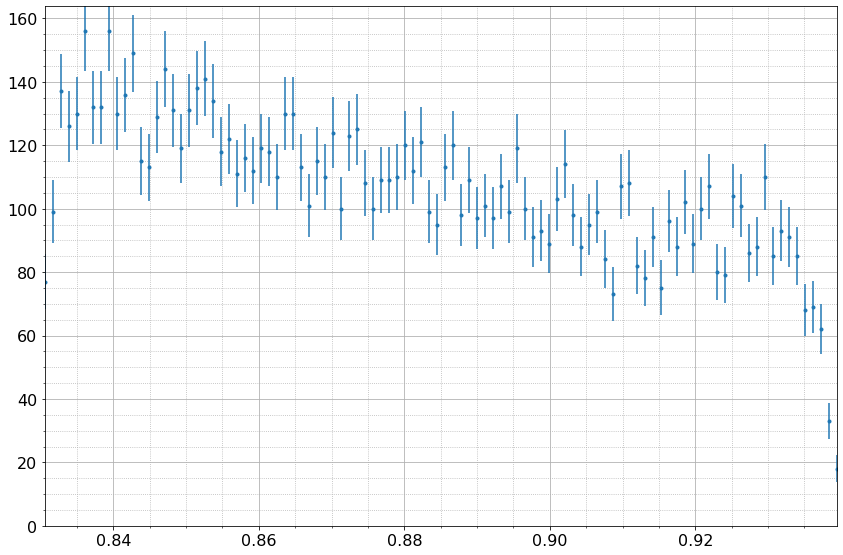

In [17]:
poisson_hist(pinutup.tau_pi_p, xlabel='');

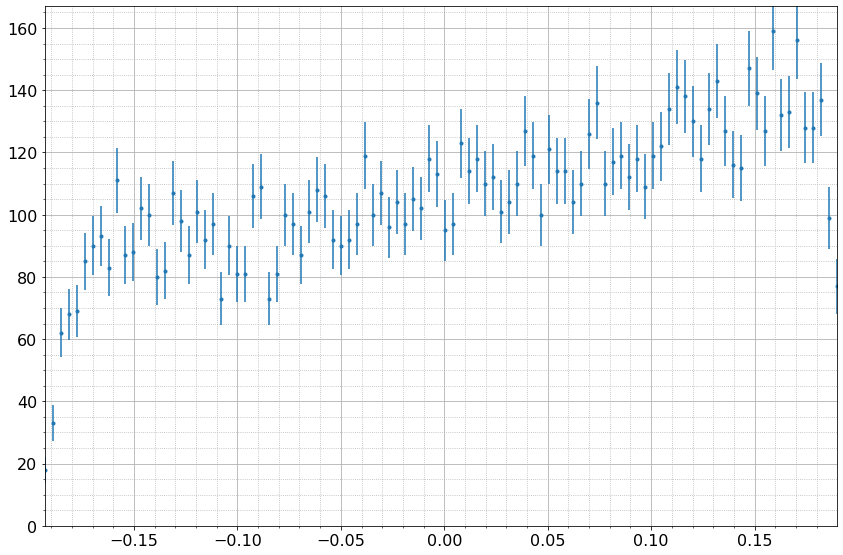

In [18]:
poisson_hist(pinutup.mmiss, xlabel='');

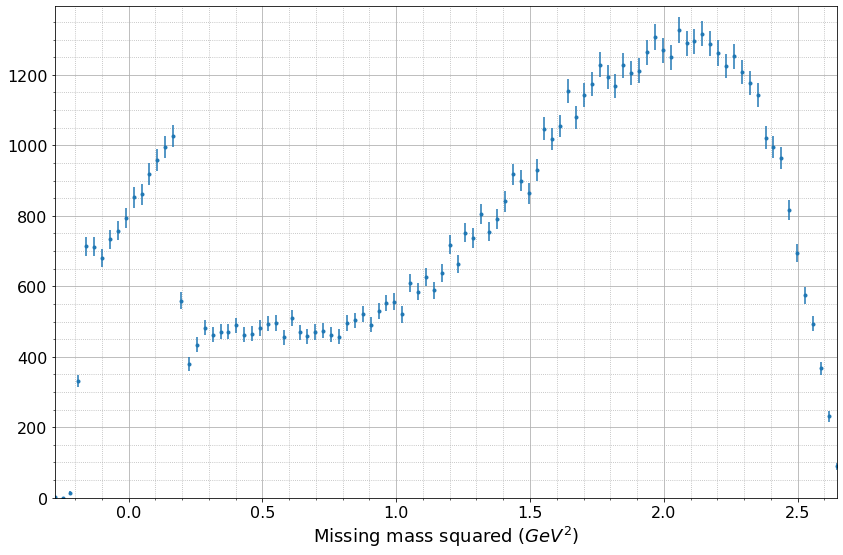

In [19]:
poisson_hist(pitup.mmiss, xlabel=r'Missing mass squared ($GeV^2$)');

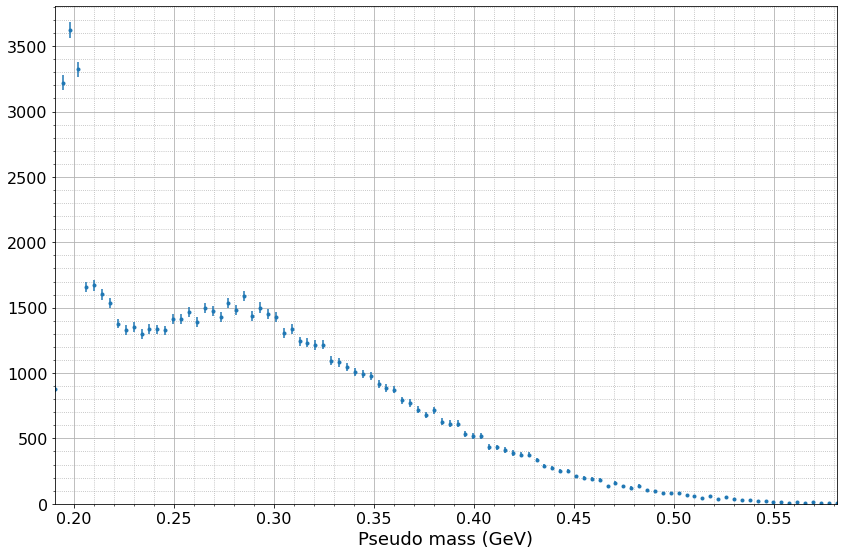

In [20]:
poisson_hist(pitup.Mp, xlabel='Pseudo mass (GeV)');

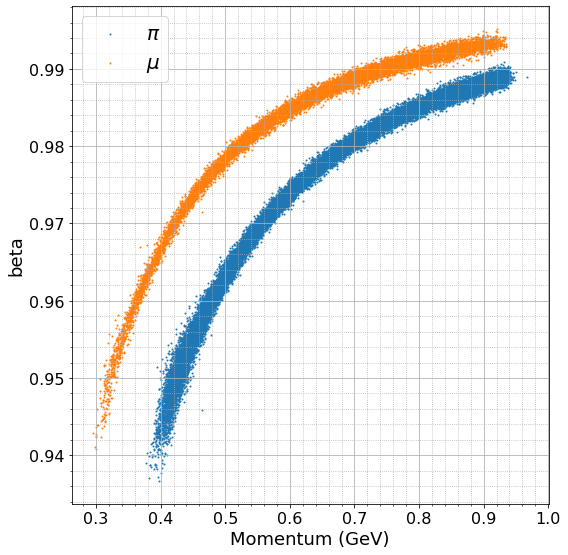

In [44]:
_, ax = plot_scatter(pitup.tau_pi_p[pitup.beta>0], pitup.beta[pitup.beta>0], 'Momentum (GeV)', 'beta', r'$\pi$');
ax.scatter(mutup.tau_pi_p[mutup.beta>0], mutup.beta[mutup.beta>0], s=1, label=r'$\mu$')
ax.legend(fontsize=20);

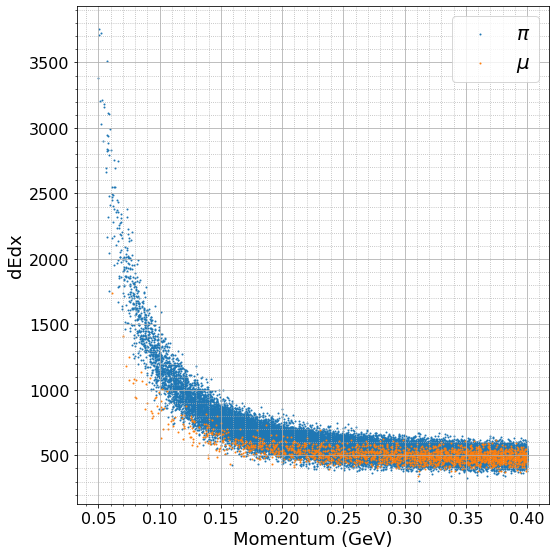

In [43]:
pimask = (pitup.dedx>0) & (pitup.p < 0.4)
mumask = (mutup.dedx>0) & (mutup.p < 0.4)
_, ax = plot_scatter(pitup.p[pimask], pitup.dedx[pimask], 'Momentum (GeV)', 'dEdx', r'$\pi$');
ax.scatter(mutup.p[mumask], mutup.dedx[mumask], s=1, label=r'$\mu$')
ax.legend(fontsize=20);

## PID Classifier

In [25]:
mudata = mutup[['p', 'pt', 'dedx', 'beta', 'nphe']].to_numpy()
pidata = pitup[['p', 'pt', 'dedx', 'beta', 'nphe']].to_numpy()
mudata.shape, pidata.shape

((14355, 5), (77175, 5))

In [26]:
X = np.vstack([mudata, pidata])
y = np.concatenate([
    np.zeros(mudata.shape[0]),
    np.ones(pidata.shape[0])
])

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
import xgboost as xgb
import joblib
from clulib import draw_predictions
import os

In [28]:
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(Xscaled, y, test_size=0.2, random_state=47)
X_train.shape

(73224, 5)

In [30]:
param = {'max_depth':3, 'eta':0.5, 'objective':'binary:logistic'}
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [31]:
use_models = True

In [32]:
%%time
xgb_model_fname = 'models/xgb_mupi_tau.joblib'
if use_models and os.path.isfile(xgb_model_fname):
    bst = joblib.load(xgb_model_fname)
else:
    bst = xgb.train(param, dtrain, num_boost_round=150)
    joblib.dump(bst, xgb_model_fname)

CPU times: user 45.3 ms, sys: 0 ns, total: 45.3 ms
Wall time: 19.3 ms


In [33]:
xgb_prob = bst.predict(dtest)
xgb_pred = xgb_prob > 0.5

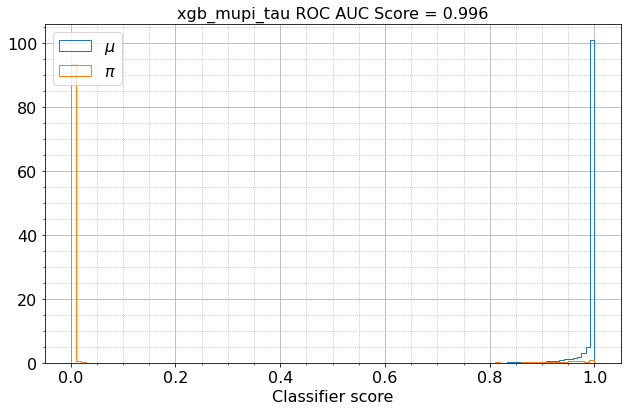

In [34]:
draw_predictions(xgb_prob, y_test, key=f'xgb_mupi_tau', type1=r'$\mu$', type2=r'$\pi$')

In [35]:
X_test_restored = scaler.inverse_transform(X_test)

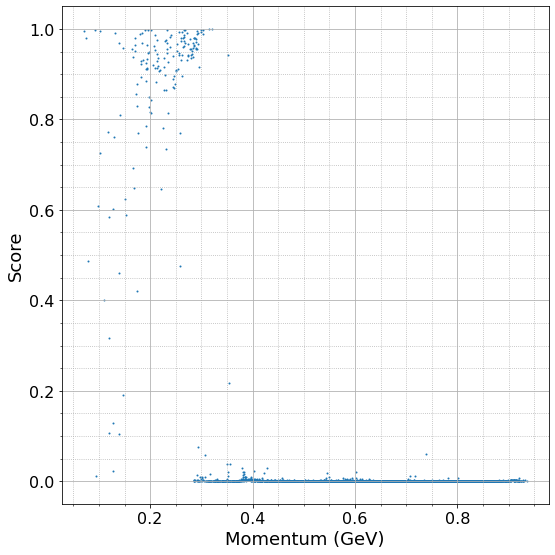

In [36]:
plot_scatter(X_test_restored[y_test==0][:, 0], xgb_prob[y_test==0], 'Momentum (GeV)', 'Score');

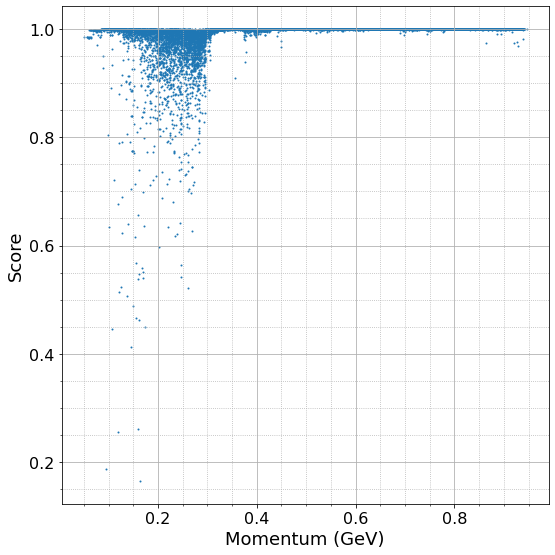

In [37]:
plot_scatter(X_test_restored[y_test==1][:, 0], xgb_prob[y_test==1], 'Momentum (GeV)', 'Score');

In [38]:
roc_auc_score(y_test, xgb_prob)

0.9960173258125884

In [39]:
accuracy_score(y_test, xgb_pred)

0.9910958155795914

In [40]:
precision_recall_fscore_support(y_test, xgb_pred)

(array([0.99627838, 0.99020424]),
 array([0.9459364 , 0.99935384]),
 array([0.97045496, 0.994758  ]),
 array([ 2830, 15476]))